# Tier 2. Module 2: Numerical Programming in Python

## Topic 6 - Fourier series and analysis in mathematics
## Homework

Application of Fourier transformations to build a spectrogram of sound signals, which is a preparatory stage for classification. You will use the ESC-50 dataset to define spectrograms and further cluster observations to identify sounds of similar origin.

This will help to consolidate the following skills:
* calculation of the Fourier transform;
* application of fast Fourier transformation in sound processing in order to generate features that can be used for clustering or classification.

### Task
For this task it's required to download the ESC-50 data set.

In [38]:
import os
import pandas as pd
import zipfile
from urllib.request import urlretrieve

url = "https://github.com/karoldvl/ESC-50/archive/master.zip"
zip_file_path = "ESC-50-master.zip"
download_path = "./ESC-50-master/"
if not os.path.exists(download_path):
    urlretrieve(url, zip_file_path)
    with zipfile.ZipFile(zip_file_path, "r") as zip_ref:
        zip_ref.extractall(download_path)
    os.remove(zip_file_path)

df_file_path = os.path.join(download_path, "ESC-50-master/meta", "esc50.csv")
df = pd.read_csv(df_file_path)
df.head(5)

filename  fold  target        category  esc10  src_file take
0   1-100032-A-0.wav     1       0             dog   True    100032    A
1  1-100038-A-14.wav     1      14  chirping_birds  False    100038    A
2  1-100210-A-36.wav     1      36  vacuum_cleaner  False    100210    A
3  1-100210-B-36.wav     1      36  vacuum_cleaner  False    100210    B
4  1-101296-A-19.wav     1      19    thunderstorm  False    101296    A

In [39]:
df.shape

(2000, 7)

Downloading an audio file using `librosa`

In [40]:
import librosa
from IPython.display import Audio

audio_file_path = os.path.join(download_path, "ESC-50-master/audio", df[:1].filename[0])
y, sr = librosa.load(audio_file_path, sr=None)

print(f"Downloaded audio file: {audio_file_path}")
print(f"Audio length: {len(y)} samples")
print(f"Sampling frequency: {sr} Hz")

Audio(audio_file_path)

Downloaded audio file: ./ESC-50-master/ESC-50-master/audio\1-100032-A-0.wav
Audio length: 220500 samples
Sampling frequency: 44100 Hz


Image of a graph of amplitude versus time

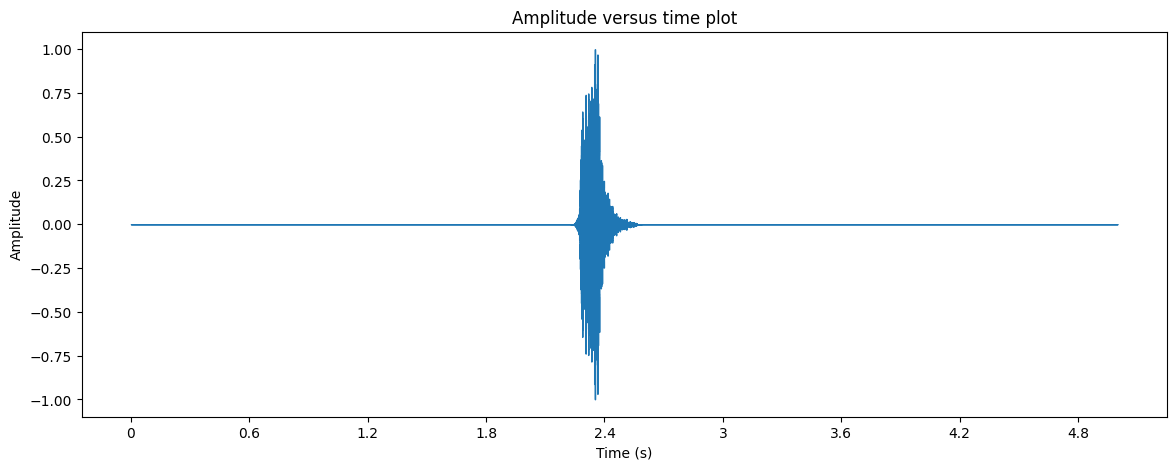

In [41]:
import librosa.display
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))
librosa.display.waveshow(y, sr=sr)
plt.title("Amplitude versus time plot")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

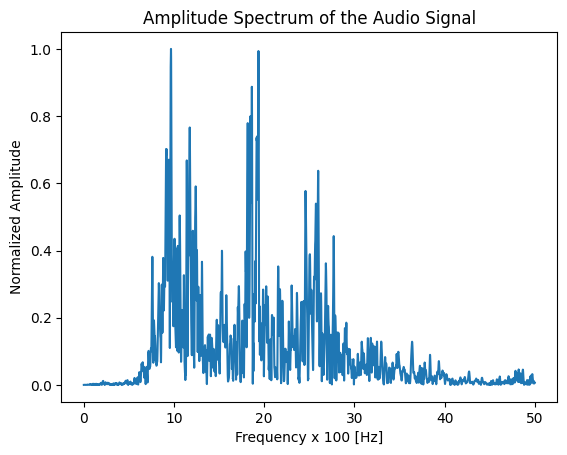

Dominant Frequencies:  [ 9.08163265  9.08390023  9.0861678   9.08843537  9.09070295  9.09297052
  9.0952381   9.09750567  9.09977324  9.10204082  9.10430839  9.10657596
  9.10884354  9.11111111  9.11337868  9.11564626  9.11791383  9.12018141
  9.12244898  9.12471655  9.12698413  9.1292517   9.13151927  9.13378685
  9.13605442  9.138322    9.14058957  9.14285714  9.14512472  9.14739229
  9.14965986  9.15192744  9.15419501  9.15646259  9.15873016  9.16099773
  9.16326531  9.16553288  9.16780045  9.17006803  9.1723356   9.17460317
  9.17687075  9.17913832  9.1814059   9.18367347  9.18594104  9.18820862
  9.19047619  9.19274376  9.19501134  9.19727891  9.19954649  9.20181406
  9.20408163  9.20634921  9.20861678  9.21088435  9.21315193  9.2154195
  9.21768707  9.38095238  9.38321995  9.38548753  9.3877551   9.39002268
  9.39229025  9.39455782  9.3968254   9.39909297  9.40136054  9.40362812
  9.40589569  9.40816327  9.41043084  9.41269841  9.41496599  9.41723356
  9.41950113  9.42176871  9.4

In [42]:
import numpy as np
from scipy.fft import fft

audio_signal = y
num_samples = sr
sampling_rate = 100


# Perform the Fourier Transform on the mystery signal
mystery_signal_fft = fft(audio_signal)

# Compute the amplitude spectrum
amplitude_spectrum = np.abs(mystery_signal_fft)

# Normalize the amplitude spectrum
amplitude_spectrum = amplitude_spectrum / np.max(amplitude_spectrum)

# Compute the frequency array
freqs = np.fft.fftfreq(num_samples, 1 / sampling_rate)

# Plot the amplitude spectrum in the frequency domain
plt.plot(freqs[: num_samples // 2], amplitude_spectrum[: num_samples // 2])
plt.xlabel(f"Frequency x {sampling_rate} [Hz]")
plt.ylabel("Normalized Amplitude")
plt.title("Amplitude Spectrum of the Audio Signal")
plt.show()

# Find the dominant frequencies
threshold = 0.6
dominant_freq_indices = np.where(amplitude_spectrum[: num_samples // 2] >= threshold)[0]
dominant_freqs = freqs[dominant_freq_indices]

print("Dominant Frequencies: ", dominant_freqs)

#### 1. To reduce the amount of data, make a sample of sounds with the labels `'dog'` and `'chirping_birds'`.

In [43]:
samples = ["dog", "chirping_birds"]
df_sample = df[df["category"].isin(samples)]
df_sample.shape

(80, 7)

In [180]:
frequency = df_sample["category"].value_counts()
frequency

category
dog               40
chirping_birds    40
Name: count, dtype: int64

#### 2. Generate a spectrogram matrix with `spectrogram` function.

In [44]:
import numpy as np


def spectrogram(samples, sample_rate, stride_ms=10.0, window_ms=20.0, eps=1e-14):

    stride_size = int(0.001 * sample_rate * stride_ms)
    window_size = int(0.001 * sample_rate * window_ms)

    # Extract strided windows
    truncate_size = (len(samples) - window_size) % stride_size
    samples = samples[: len(samples) - truncate_size]
    nshape = (window_size, (len(samples) - window_size) // stride_size + 1)
    nstrides = (samples.strides[0], samples.strides[0] * stride_size)
    windows = np.lib.stride_tricks.as_strided(samples, shape=nshape, strides=nstrides)

    assert np.all(windows[:, 1] == samples[stride_size : (stride_size + window_size)])

    # Window weighting, squared Fast Fourier Transform (fft), scaling
    weighting = np.hanning(window_size)[:, None]

    fft = np.fft.rfft(windows * weighting, axis=0)
    fft = np.absolute(fft)
    fft = fft**2

    scale = np.sum(weighting**2) * sample_rate
    fft[1:-1, :] *= 2.0 / scale
    fft[(0, -1), :] /= scale

    # Compute spectrogram feature
    specgram = np.log(fft[:, :] + eps)
    return specgram

In [45]:
specgram = spectrogram(y, sr)

In [54]:
import plotly.graph_objects as go


def spect_show(spect_matrix):
    plt.imshow(spect_matrix, cmap="viridis", interpolation="nearest")
    plt.colorbar()
    plt.title("Visualization of the spectral matrix")
    plt.xlabel("Frame number")
    plt.ylabel("Frequency")
    plt.show()


def spect_go_show(spect_matrix, desc):
    fig = go.Figure(data=go.Heatmap(z=spect_matrix, colorscale="viridis"))
    fig.update_layout(
        title=f"Visualization of the spectral matrix {desc}",
        xaxis_title="Frame number",
        yaxis_title="Frequency",
    )
    fig.show()

In [55]:
spect_go_show(specgram, "dog")

#### 3. Use the `pooling` function to generalize and reduce the size of the spectrogram.

In [48]:
def pooling_audio(mat, ksize, method="max", pad=False):
    """Non-overlapping pooling on 2D or 3D data.

    <mat>: ndarray, input array to pool.
    <ksize>: tuple of 2, kernel size in (ky, kx).
    <method>: str, 'max for max-pooling, 'mean' for mean-pooling.
    <pad>: bool, pad <mat> or not. If no pad, output has size
            n//f, n being <mat> size, f being kernel size.
            if pad, output has size ceil(n/f).

    Return <result>: pooled matrix.
    """

    m, n = mat.shape[:2]
    ky, kx = ksize

    _ceil = lambda x, y: int(np.ceil(x / float(y)))

    if pad:
        ny = _ceil(m, ky)
        nx = _ceil(n, kx)
        size = (ny * ky, nx * kx) + mat.shape[2:]
        mat_pad = np.full(size, np.nan)
        mat_pad[:m, :n, ...] = mat
    else:
        ny = m // ky
        nx = n // kx
        mat_pad = mat[: ny * ky, : nx * kx, ...]

    new_shape = (ny, ky, nx, kx) + mat.shape[2:]

    if method == "max":
        result = np.nanmax(mat_pad.reshape(new_shape), axis=(1, 3))
    else:
        result = np.nanmean(mat_pad.reshape(new_shape), axis=(1, 3))

    return result

In [56]:
specgram_simple = pooling_audio(specgram, (10, 10))

In [57]:
spect_go_show(specgram_simple, "pooled")

#### 4. Using the `flatten()` method, convert the spectrogram matrix into a vector for further spectral analysis.

In [72]:
spect_vector = specgram_simple.flatten()
spect_vector.shape

(2156,)

All the transformations combined

In [156]:
def load_audio(audio_file_path, frame=(75, 75), method="max"):
    y, sr = librosa.load(audio_file_path, sr=None)
    specgram = np.abs(librosa.stft(y))  # short-time Fourier transform
    # specgram = spectrogram(y, sr) # fast Fourier transform

    pooled_spec = pooling_audio(specgram, frame, method=method)
    flattened_spec = pooled_spec.flatten()

    return flattened_spec

#### 5. Use the `SpectralClustering` function of the `sklearn` library to cluster the received data.

Generating data for the spectral clustering

In [157]:
location = os.path.join(download_path, "ESC-50-master/audio")

audio_data = [
    load_audio(os.path.join(location, f_name)) for f_name in df_sample.filename
]
print("Number of samples:", len(audio_data))
print("Number of features in a sample:", len(audio_data[0]))

Number of samples: 80
Number of features in a sample: 65


In [158]:
true_labels = df_sample.category
mapped_values = {"dog": 0, "chirping_birds": 1}
true_labels = true_labels.replace(mapped_values)
len(true_labels)

C:\Users\danie\AppData\Local\Temp\ipykernel_101384\2886242488.py:3: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



80

Spectral Clustering

In [159]:
import copy

from sklearn.cluster import SpectralClustering
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import adjusted_rand_score, confusion_matrix
from sklearn.preprocessing import StandardScaler

param_grid = {
    "n_clusters": [2],
    "affinity": ["nearest_neighbors"],
    "gamma": [1, 10, 50, 100],
    "assign_labels": ["kmeans", "discretize", "cluster_qr"],
}

scaler = StandardScaler()

shapes = [data.shape for data in audio_data]
max_shape = max(shapes)  # Find the max shape

# Reshape all elements to have the same shape
audio_data_fixed = [
    (
        np.pad(data, [(0, max_shape[0] - data.shape[0])], mode="constant")
        if data.shape != max_shape
        else data
    )
    for data in audio_data
]

X_normalized = scaler.fit_transform(audio_data_fixed)

best_accuracy = 0
best_precision = 0  # Initialize the best ARI
best_params = None  # Initialize the best parameters

# Iterate over all combinations of hyperparameters
for n_clusters in param_grid["n_clusters"]:
    for affinity in param_grid["affinity"]:
        for gamma in param_grid["gamma"]:
            for assign_labels in param_grid["assign_labels"]:
                # Create the SpectralClustering model with current hyperparameters
                model = SpectralClustering(
                    n_clusters=n_clusters,
                    affinity=affinity,
                    gamma=gamma,
                    assign_labels=assign_labels,
                    random_state=42,
                )

                try:
                    # Perform clustering
                    clusters = model.fit_predict(X_normalized)
                except Exception as e:
                    print(e)

                # Evaluate the clustering performance using ARI
                ari = adjusted_rand_score(true_labels, clusters)
                accuracy = accuracy_score(true_labels, clusters)
                precision = precision_score(true_labels, clusters)
                recall = recall_score(true_labels, clusters)
                f1 = f1_score(true_labels, clusters)

                # Compute confusion matrix
                conf_matrix = confusion_matrix(true_labels, clusters)
                # Calculate the sum of diagonal elements (correct predictions)
                correct_predictions = np.trace(conf_matrix)

                # Calculate the total number of predictions
                total_predictions = np.sum(conf_matrix)

                # Calculate accuracy
                accuracy = correct_predictions / total_predictions

                # Update the best parameters if ARI is improved
                if precision > best_precision:
                    best_precision = precision
                    best_params = {
                        "n_clusters": n_clusters,
                        "affinity": affinity,
                        "gamma": gamma,
                        "assign_labels": assign_labels,
                    }
                    best_clusters = copy.copy(clusters)
                    best_accuracy = accuracy

                    # Print metrics for each combination
                    print("Parameters:", best_params)
                    print("Adjusted Rand Index (ARI):", ari)
                    print("Accuracy:", accuracy)
                    print("Precision:", precision)
                    print("Recall:", recall)
                    print("F1-score", f1)
                    print()

# Print the best parameters found
print("\33[32mBest Parameters:", best_params)
print("\33[32mAdjusted Rand Index (ARI) of the best model:", best_accuracy)

Parameters: {'n_clusters': 2, 'affinity': 'nearest_neighbors', 'gamma': 1, 'assign_labels': 'kmeans'}
Adjusted Rand Index (ARI): 0.6355715017939518
Accuracy: 0.9
Precision: 0.8333333333333334
Recall: 1.0
F1-score 0.9090909090909091

Parameters: {'n_clusters': 2, 'affinity': 'nearest_neighbors', 'gamma': 1, 'assign_labels': 'cluster_qr'}
Adjusted Rand Index (ARI): 0.6766574021417873
Accuracy: 0.9125
Precision: 0.851063829787234
Recall: 1.0
F1-score 0.9195402298850575

Best Parameters: {'n_clusters': 2, 'affinity': 'nearest_neighbors', 'gamma': 1, 'assign_labels': 'cluster_qr'}
Adjusted Rand Index (ARI) of the best model 0


#### 6. Analyze the obtained clusters. Did sounds of different origins fall into different clusters?

In [177]:
clusters = best_clusters
df_sample["predicted"] = clusters
df_sample.loc[df_sample["predicted"] == 0, "predicted"] = "dog"
df_sample.loc[df_sample["predicted"] == 1, "predicted"] = "chirping_birds"
df_sample.tail(5)

C:\Users\danie\AppData\Local\Temp\ipykernel_101384\770702547.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\danie\AppData\Local\Temp\ipykernel_101384\770702547.py:3: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'dog' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.



filename  fold  target        category  esc10  src_file take  \
1919  5-243450-A-14.wav     5      14  chirping_birds  False    243450    A   
1920  5-243459-A-14.wav     5      14  chirping_birds  False    243459    A   
1921  5-243459-B-14.wav     5      14  chirping_birds  False    243459    B   
1972  5-257839-A-14.wav     5      14  chirping_birds  False    257839    A   
1999     5-9032-A-0.wav     5       0             dog   True      9032    A   

           predicted  
1919  chirping_birds  
1920  chirping_birds  
1921  chirping_birds  
1972  chirping_birds  
1999             dog

Confusion Matrix

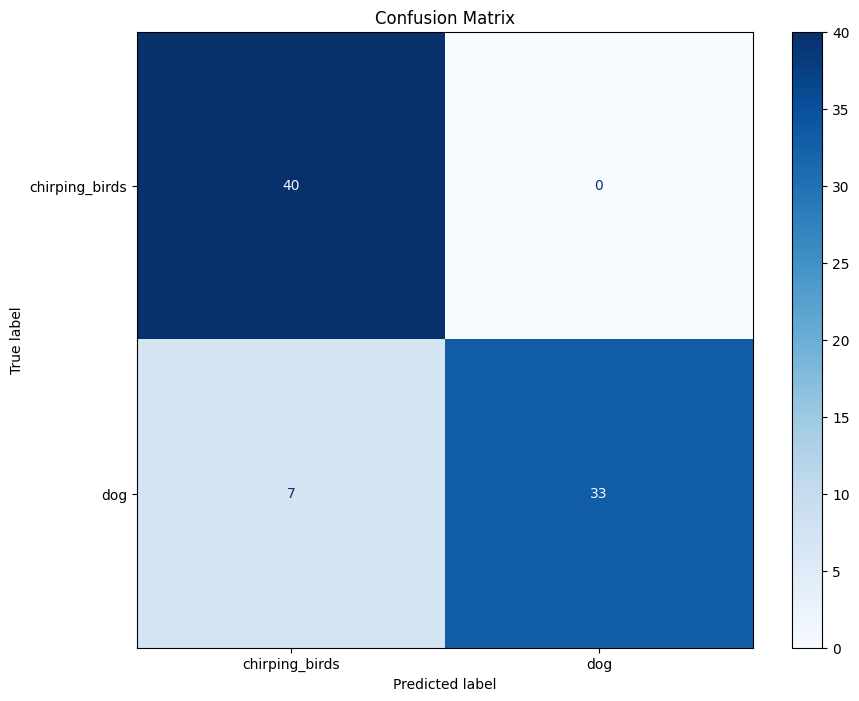

In [187]:
from sklearn.metrics import ConfusionMatrixDisplay


final_conf_matrix = confusion_matrix(df_sample["category"], df_sample["predicted"])

disp = ConfusionMatrixDisplay(
    confusion_matrix=final_conf_matrix,
    display_labels=df_sample["category"].unique()[::-1],
)
fig, ax = plt.subplots(figsize=(10, 8))
disp.plot(ax=ax, cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

In [182]:
freq = df_sample["predicted"].value_counts()
freq

predicted
chirping_birds    47
dog               33
Name: count, dtype: int64

7 dog sounds were misclassified as bird sounds.

#### 7. Conclusion:

* SpectralClustering showed acceptable results with an accuracy of 91.25% in separating dog and bird sounds into two groups.
* 7 clustering errors were made when dog sounds were assigned to birds. As shown in the spectral matrix visualization in chapter 2, these spurious samples were very short in time (most of the recording was silence) and therefore did not contain enough information for proper clustering.
* The accuracy of the clustering is highly dependent on the audio pooling when creating the spectral matrix. On this dataset, the optimal value (accuracy of 91.25%) is a kernel size of 75 x 75. When it is reduced below 50 x 50, the clustering error starts to increase sharply, and the accuracy drops to 50%.